Found 132 good matches out of 4668 total
Affine matrix:
 [[ 9.94704559e-01  1.72165407e-03  3.07133296e+01]
 [-1.72165407e-03  9.94704559e-01  2.69665135e+00]]


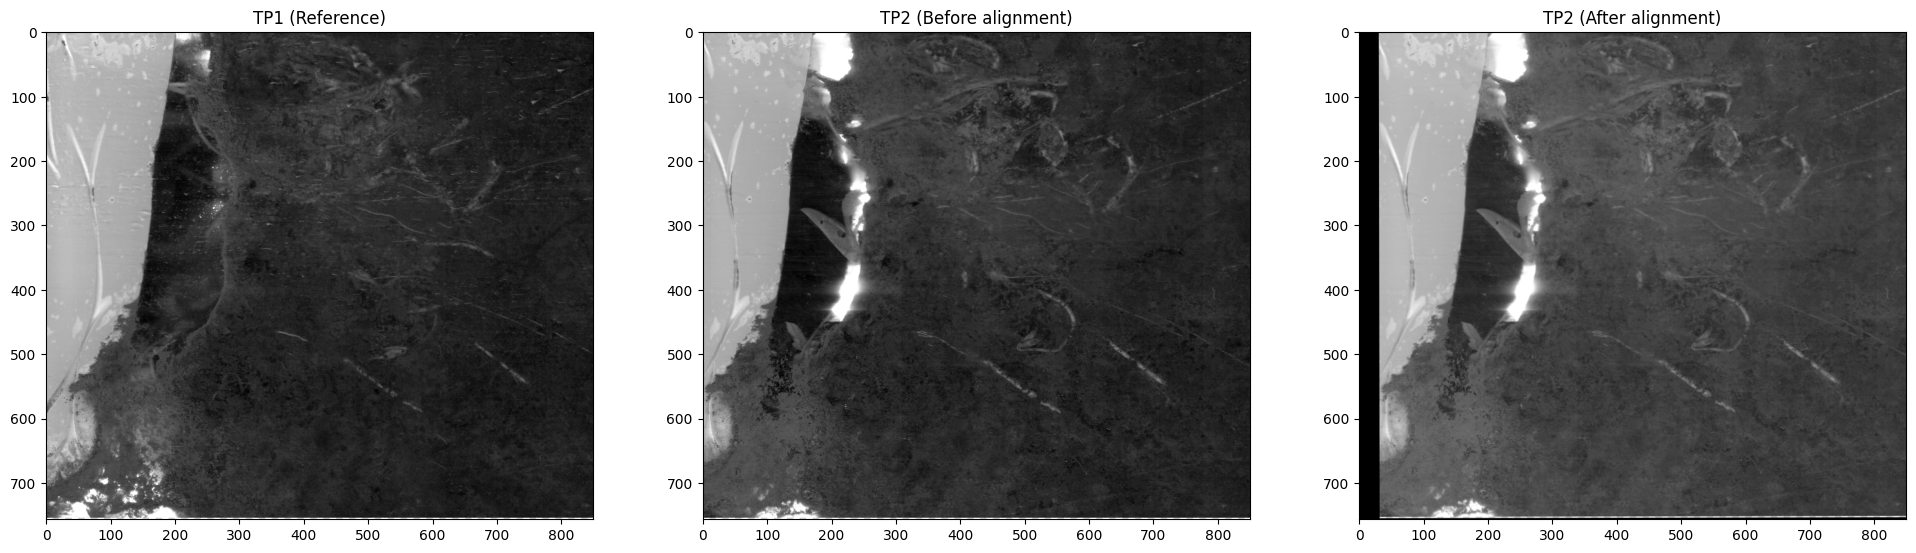

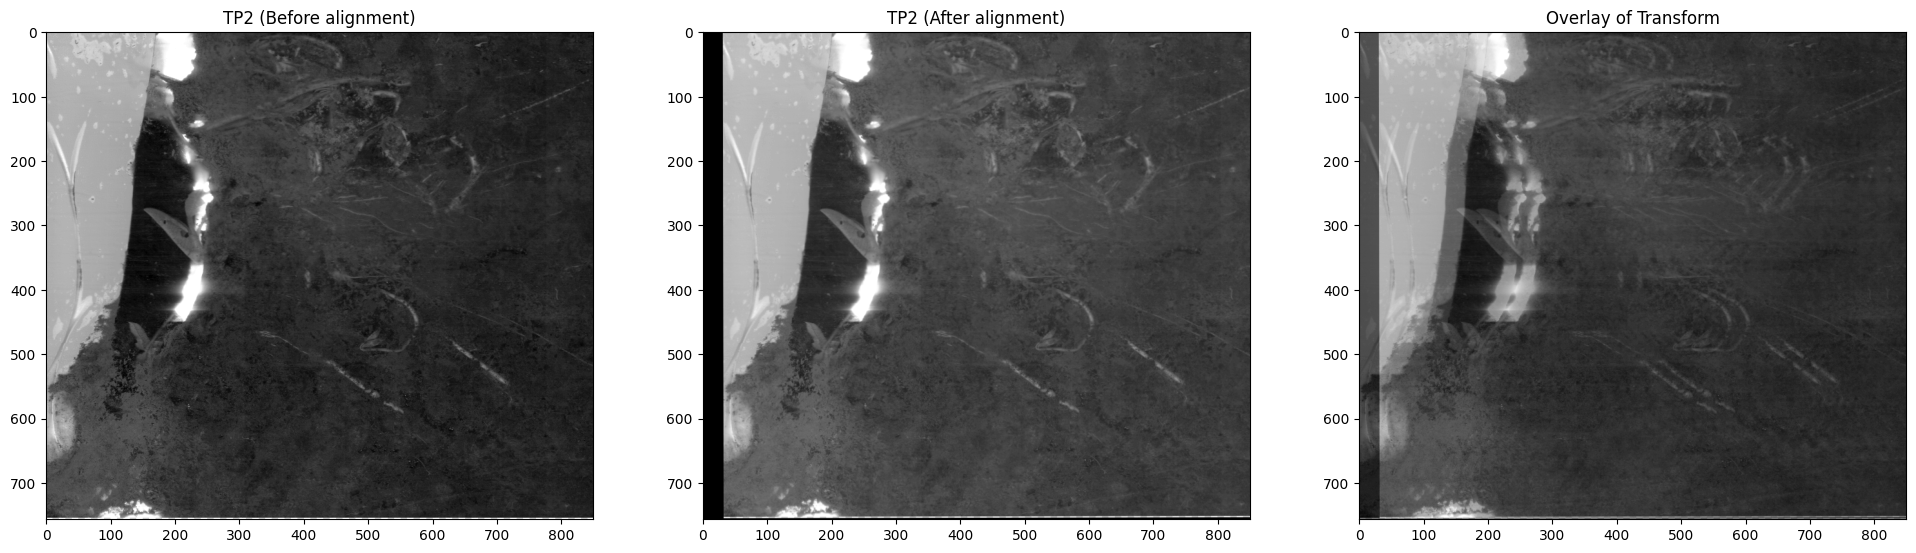

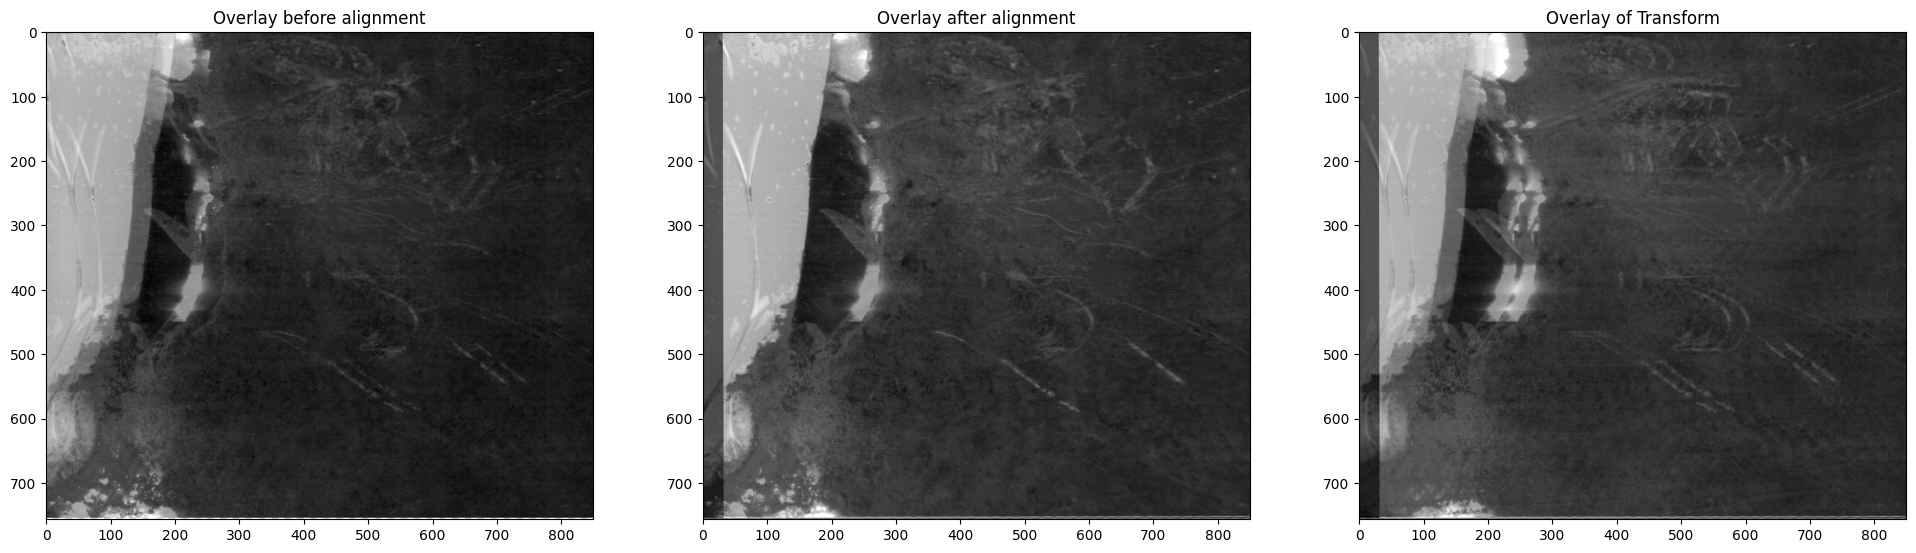

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load or prepare your grayscale images ---
# Replace these lines with your own file paths or image arrays
# img1 = cv.imread("slu_data/kura_201_001_2024-03-11_TP1.png", cv.IMREAD_GRAYSCALE)
# img2 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# img1 = cv.imread("slu_data/kura_201_001_2024-03-26_TP2.png", cv.IMREAD_GRAYSCALE)
# img2 = cv.imread("slu_data/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)
img1 = cv.imread("slu_data/slu_data_201/kura_201_001_2024-04-09_TP3.png", cv.IMREAD_GRAYSCALE)  # reference (earlier)
img2 = cv.imread("slu_data/slu_data_201/kura_201_1_2024-04-22_TP4.png", cv.IMREAD_GRAYSCALE)  # moving (later)

# Optional: small blur & contrast normalization to improve feature stability
def preprocess(img):
    img = cv.GaussianBlur(img, (3, 3), 0)
    img = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img)
    return img

I1, I2 = preprocess(img1), preprocess(img2)

# --- 1. Detect and describe keypoints ---
sift = cv.SIFT_create()  # or cv.AKAZE_create() / cv.ORB_create() for speed
kp1, des1 = sift.detectAndCompute(I1, None)
kp2, des2 = sift.detectAndCompute(I2, None)

# --- 2. Match descriptors with ratio test ---
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Lowe's ratio test
        good.append(m)

print(f"Found {len(good)} good matches out of {len(matches)} total")

# --- 3. Estimate affine transform using RANSAC ---
if len(good) >= 3:  # need at least 3 points for affine
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    M, inliers = cv.estimateAffinePartial2D(
        pts2, pts1,
        method=cv.RANSAC,
        ransacReprojThreshold=3.0,
        maxIters=2000,
        confidence=0.99
    )

    print("Affine matrix:\n", M)

    # --- 4. Warp moving image ---
    aligned = cv.warpAffine(
        img2, M, (img2.shape[1], img2.shape[0]),
        flags=cv.INTER_LINEAR
    )

    # --- 5. Quick visual check ---
    overlay = cv.addWeighted(img1, 0.5, aligned, 0.5, 0)

    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1); plt.imshow(img1, cmap='gray'); plt.title("TP1 (Reference)")
    plt.subplot(1,3,2); plt.imshow(img2, cmap='gray'); plt.title("TP2 (Before alignment)")
    plt.subplot(1,3,3); plt.imshow(aligned, cmap='gray'); plt.title("TP2 (After alignment)")
    plt.show()

    blend_prior = cv.addWeighted(img1, 0.5, img2, 0.5, 0)
    blend_transform = cv.addWeighted(img2, 0.5, aligned, 0.5, 0)

    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1); plt.imshow(img2, cmap='gray'); plt.title("TP2 (Before alignment)")
    plt.subplot(1,3,2); plt.imshow(aligned, cmap='gray'); plt.title("TP2 (After alignment)")
    plt.subplot(1,3,3); plt.imshow(blend_transform, cmap='gray'); plt.title("Overlay of Transform")
    plt.show()

    plt.figure(figsize=(24,12))
    plt.subplot(1,3,1); plt.imshow(blend_prior, cmap='gray'); plt.title("Overlay before alignment")
    plt.subplot(1,3,2); plt.imshow(overlay, cmap='gray'); plt.title("Overlay after alignment")
    plt.subplot(1,3,3); plt.imshow(blend_transform, cmap='gray'); plt.title("Overlay of Transform")
    plt.show()

else:
    print("Not enough good matches for reliable registration.")
